
# √Årvore de Decis√£o ‚Äî Sele√ß√£o de Analista Financeiro

Notebook educativo preparado para o curso **Introdu√ß√£o ao Machine Learning com Python (UNIVALI)**.

**Objetivo:** Treinar um classificador de **√Årvore de Decis√£o** para **selecionar candidatos** a uma vaga de **Analista Financeiro**,
mostrando **impureza (Gini/Entropia)**, **ganho de informa√ß√£o**, **visualiza√ß√£o da √°rvore** e **m√©tricas de avalia√ß√£o**.

> O notebook **l√™ um CSV** com candidatos e conduz o processo de ponta a ponta.


In [1]:
# %% [setup] Importa√ß√µes e Configura√ß√£o

# Bibliotecas fundamentais para an√°lise de dados e visualiza√ß√£o
import pandas as pd              # Para manipula√ß√£o e an√°lise de dados estruturados
import numpy as np              # Para computa√ß√£o num√©rica e arrays
import matplotlib.pyplot as plt  # Para cria√ß√£o de gr√°ficos e visualiza√ß√µes

# Importa√ß√µes do scikit-learn para machine learning
# Fun√ß√£o para dividir dados em conjuntos de treino e teste
from sklearn.model_selection import train_test_split
# Transformador para converter vari√°veis categ√≥ricas em num√©ricas
from sklearn.preprocessing import OneHotEncoder
# Para combinar diferentes transformadores em um pipeline
from sklearn.compose import ColumnTransformer
# Para criar pipelines de processamento e modelo
from sklearn.pipeline import Pipeline
# M√©tricas de avalia√ß√£o para modelos de classifica√ß√£o
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
# Algoritmo de √°rvore de decis√£o e fun√ß√£o para visualiza√ß√£o
from sklearn.tree import DecisionTreeClassifier, plot_tree
# import da biblioteca os para verificar caminho
import os  

np.random.seed(42)                        # Define uma semente para reprodutibilidade dos resultados aleat√≥rios

In [2]:
csv_path = r"../Datasets/candidatos_financeiro.csv"  # caminho do arquivo CSV

df = pd.read_csv(csv_path)  # carrega o CSV em um DataFrame pandas
print("Dimens√µes:", df.shape)  # imprime n√∫mero de linhas e colunas
df.head()  # mostra as primeiras linhas do DataFrame para inspe√ß√£o

Dimens√µes: (160, 10)


experiencia_anos  certificacao_financeira    ingles  excel_avancado  \
0               5.6                        0    B√°sico               0   
1               4.2                        1    B√°sico               0   
2               5.9                        0    B√°sico               0   
3               7.9                        1    B√°sico               1   
4               4.0                        0  Avan√ßado               1   

        formacao  raciocinio_logico  salario_pretendido  comunicacao  \
0  Contabilidade               51.0              5860.0          5.0   
1     Engenharia               89.0              6520.0          3.0   
2  Administra√ß√£o               83.0              6270.0          4.0   
3     Engenharia               70.0              5470.0          4.0   
4  Contabilidade               74.0              4960.0          4.0   

   disponibilidade_imediata  selecionado  
0                         1            0  
1                         0            0  
2                         0            0  
3                         1            1  
4                         1            1


## 1. Entendendo os dados
Analisamos a distribui√ß√£o das vari√°veis e a taxa de aprova√ß√£o (`selecionado`).

**An√°lise r√°pida do arquivo carregado:**
- Verifique se as dimens√µes e as colunas batem com o esperado.
- Confirme a presen√ßa da coluna `selecionado` (target).
- Observe valores ausentes, tipos de colunas e algumas linhas iniciais para checar formata√ß√£o.

In [3]:
# Exibe um resumo estat√≠stico completo do DataFrame
# include='all' garante que todas as colunas (num√©ricas e categ√≥ricas) sejam consideradas
display(df.describe(include='all'))

tx = df['selecionado'].mean()
# Imprime a taxa formatada como porcentagem com duas casas decimais
print(f"Taxa de candidatos selecionados: {tx:.2%}")

# Observa√ß√£o: verifique colunas com contagem baixa ou valores estranhos que podem afetar os modelos

experiencia_anos  certificacao_financeira  ingles  excel_avancado  \
count         160.000000               160.000000     160      160.000000   
unique               NaN                      NaN       3             NaN   
top                  NaN                      NaN  B√°sico             NaN   
freq                 NaN                      NaN      66             NaN   
mean            4.359375                 0.537500     NaN        0.425000   
std             2.036809                 0.500157     NaN        0.495895   
min             0.000000                 0.000000     NaN        0.000000   
25%             3.000000                 0.000000     NaN        0.000000   
50%             4.400000                 1.000000     NaN        0.000000   
75%             5.525000                 1.000000     NaN        1.000000   
max             9.900000                 1.000000     NaN        1.000000   

             formacao  raciocinio_logico  salario_pretendido  comunicacao  \
count             160         160.000000          160.000000   160.000000   
unique              4                NaN                 NaN          NaN   
top     Administra√ß√£o                NaN                 NaN          NaN   
freq               48                NaN                 NaN          NaN   
mean              NaN          70.887500         5352.562500     3.556250   
std               NaN          12.289991          959.466733     0.916288   
min               NaN          39.000000         3010.000000     1.000000   
25%               NaN          64.000000         4677.500000     3.000000   
50%               NaN          70.500000         5355.000000     4.000000   
75%               NaN          79.000000         5980.000000     4.000000   
max               NaN         100.000000         7780.000000     5.000000   

        disponibilidade_imediata  selecionado  
count                 160.000000   160.000000  
unique                       NaN          NaN  
top                          NaN          NaN  
freq                         NaN          NaN  
mean                    0.525000     0.381250  
std                     0.500943     0.487219  
min                     0.000000     0.000000  
25%                     0.000000     0.000000  
50%                     1.000000     0.000000  
75%                     1.000000     1.000000  
max                     1.000000     1.000000

Taxa de candidatos selecionados: 38.12%


In [4]:
# Define as vari√°veis num√©ricas que ser√£o visualizadas em histogramas
cols_num = ['experiencia_anos','raciocinio_logico','salario_pretendido','comunicacao']

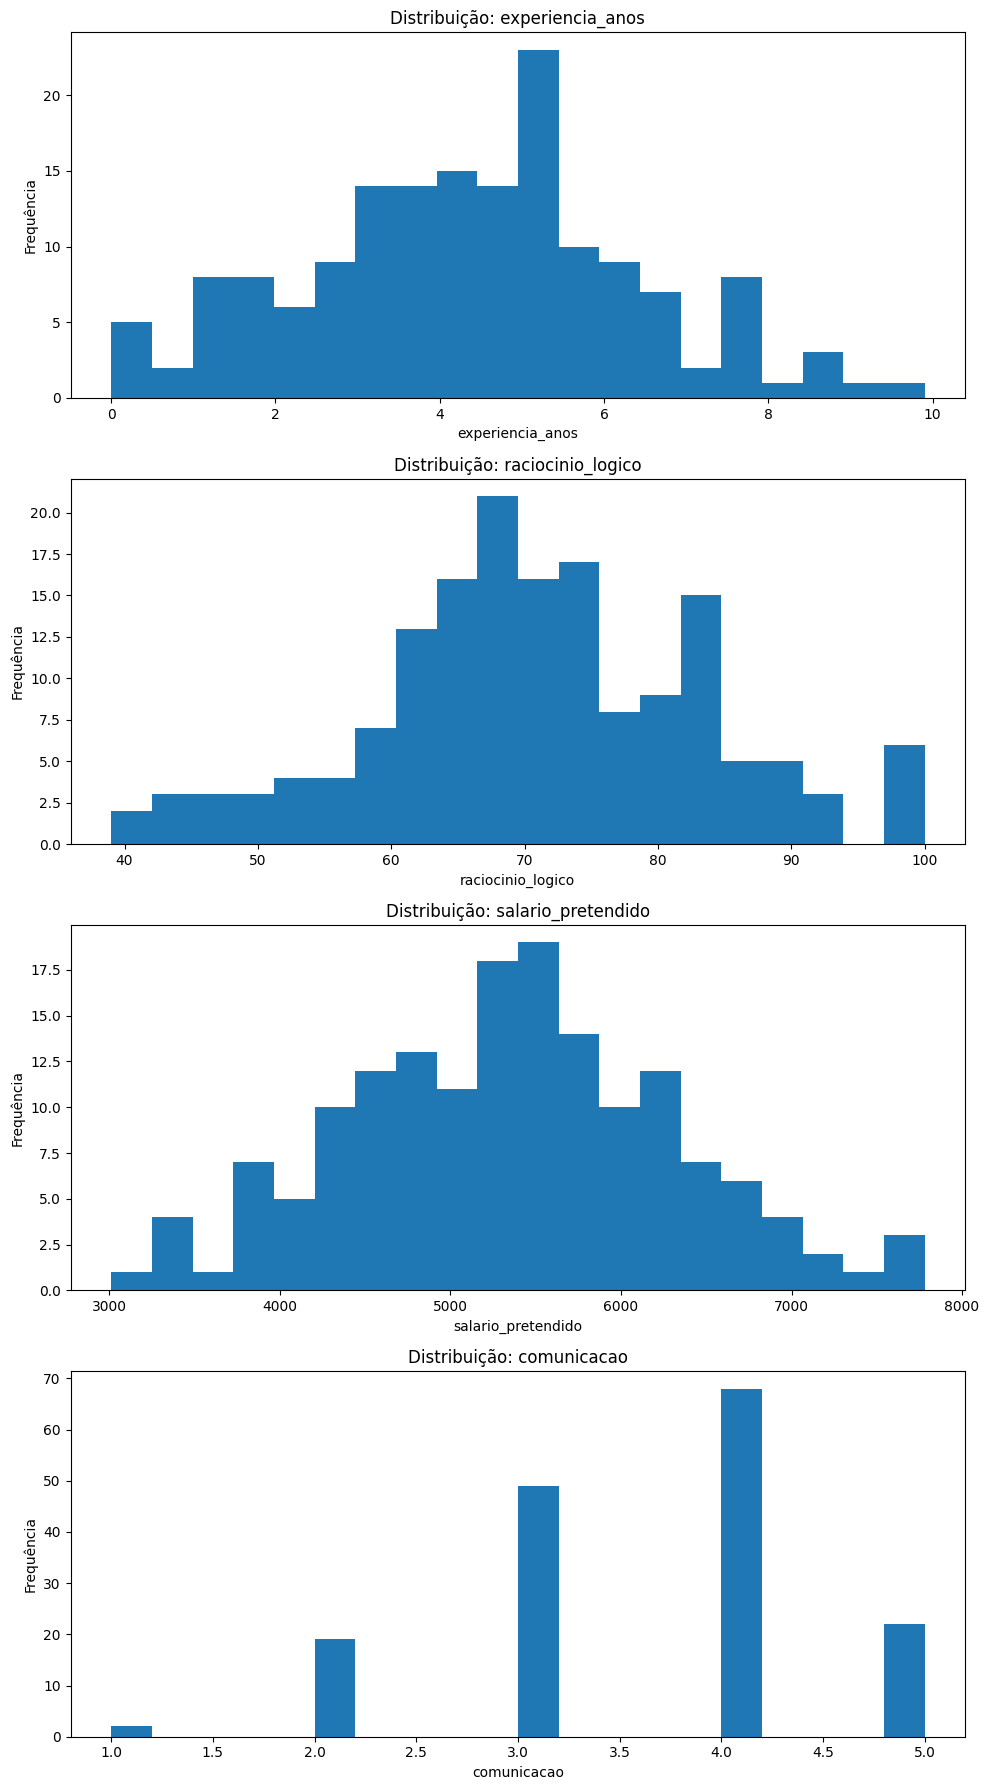

In [5]:
# Cria uma figura com subplots verticais (um para cada vari√°vel)
fig, axes = plt.subplots(len(cols_num), 1, figsize=(10, 18))

# Itera sobre os eixos e colunas simultaneamente usando zip
for ax, c in zip(axes, cols_num):
    # Cria um histograma para cada vari√°vel usando dados do DataFrame
    ax.hist(df[c].dropna(), bins=20)  # remove NaNs para n√£o quebrar o histograma
    # Adiciona um t√≠tulo descritivo para cada histograma
    ax.set_title(f"Distribui√ß√£o: {c}")
    # Adiciona r√≥tulos aos eixos para clareza
    ax.set_xlabel(c)
    ax.set_ylabel('Frequ√™ncia')

# Ajusta layout para evitar sobreposi√ß√£o
plt.tight_layout()
# Mostra o gr√°fico
plt.show()

# Observa√ß√£o: Histogramas ajudam a detectar assimetria e outliers

**Breve an√°lise do resumo estat√≠stico:**
- A tabela `describe()` mostra contagens, m√©dia, desvio padr√£o e quartis para num√©ricos; para categ√≥ricos mostra contagem e top.
- Procure por outliers em `raciocinio logico` ou contagens muito baixas em categorias.



## 2. Impureza e Ganho de Informa√ß√£o (teoria + pr√°tica)

Para classifica√ß√£o bin√°ria, as medidas de impureza mais comuns s√£o:

- **Gini:** \( Gini(S) = 1 - p^2 - (1-p)^2 \)
- **Entropia:** \( H(S) = -p \log_2 p - (1-p) \log_2 (1-p) \)

O **Ganho de Informa√ß√£o** de um split X √©:

\[ IG(S, X) = I(S) - \sum_{v \in splits} \frac{|S_v|}{|S|}\, I(S_v) \]

onde \(I\) pode ser **Gini** ou **Entropia**.

A seguir, calculamos **na m√£o** a impureza do conjunto e testamos **splits candidatos**
para uma √∫nica feature num√©rica (`experiencia_anos`) e uma categ√≥rica (`ingles`), obtendo o **melhor split** e seu ganho.


**An√°lise r√°pida dos histogramas:**
- Verifique se as distribui√ß√µes s√£o pr√≥ximas de normal ou fortemente assim√©tricas.
- Vari√°veis com baixa varia√ß√£o talvez n√£o ajudem o modelo (podem ser removidas).

In [6]:
# Fun√ß√µes auxiliares para c√°lculo de impureza e ganho de informa√ß√£o

# Fun√ß√£o para calcular o √≠ndice de Gini
def gini(y):
    # Recebe uma s√©rie/array de r√≥tulos (0/1)
    p = y.mean()  # Calcula a propor√ß√£o de r√≥tulos positivos
    # Calcula e retorna o √≠ndice de Gini: 1 - (p^2 + (1-p)^2)
    return 1 - (p**2 + (1-p)**2)

# Fun√ß√£o para calcular a Entropia
def entropy(y):
    # Recebe uma s√©rie/array de r√≥tulos (0/1)
    p = y.mean()  # Calcula a propor√ß√£o de r√≥tulos positivos
    # Se n√£o h√° diversidade de classes, entropia √© zero
    if p == 0 or p == 1:
        return 0.0
    # Calcula e retorna a entropia: -p*log2(p) - (1-p)*log2(1-p)
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))


# Fun√ß√£o para calcular ganho de informa√ß√£o entre um pai e dois filhos
def info_gain(y, y_left, y_right, impurity_fn):
    # n: tamanho do n√≥ pai
    n = len(y)
    # Se algum filho estiver vazio, n√£o consideramos esse split (ganho indefinido)
    if len(y_left) == 0 or len(y_right) == 0:
        return -np.inf
    # Impureza do n√≥ pai
    pai = impurity_fn(y)
    # Impureza ponderada dos n√≥s filhos
    filho = (len(y_left) / n) * impurity_fn(y_left) + (len(y_right) / n) * impurity_fn(y_right)
    # Retorna o ganho de informa√ß√£o (redu√ß√£o da impureza)
    return pai - filho


# Fun√ß√£o para encontrar o melhor split em uma feature num√©rica
def melhor_split_numerica(x: pd.Series, y: pd.Series, criterio="gini"):
    # Seleciona a fun√ß√£o de impureza (gini ou entropia)
    imp = gini if criterio == "gini" else entropy

    # Gera candidatos de corte como m√©dias entre valores consecutivos distintos
    xs = np.sort(x.astype(float).unique())  # Valores √∫nicos ordenados
    # Se n√£o h√° ao menos dois valores distintos, n√£o h√° split poss√≠vel
    if len(xs) < 2:
        return None  # sem split poss√≠vel

    # Calcula thresholds como pontos m√©dios entre valores adjacentes
    thresholds = (xs[:-1] + xs[1:]) / 2.0
    resultados = []  # lista para armazenar (threshold, gain, n_left, n_right)
    for t in thresholds:
        yL = y[x <= t]  # r√≥tulos do lado esquerdo do split
        yR = y[x > t]   # r√≥tulos do lado direito do split
        gain = info_gain(y, yL, yR, imp)  # calcula ganho para esse threshold
        resultados.append((t, float(gain), len(yL), len(yR)))  # armazena resultado

    # Seleciona o threshold com maior ganho
    t, gain, nL, nR = max(resultados, key=lambda r: r[1])
    # Retorna um dicion√°rio com detalhes do melhor split
    return {"feature": x.name, "threshold": float(t), "gain": gain, "n_left": nL, "n_right": nR, "criterion": criterio}


# Fun√ß√£o para encontrar o melhor split em uma feature categ√≥rica (one-vs-rest)
def melhor_split_categorica(x: pd.Series, y: pd.Series, criterio="gini"):
    # Seleciona a fun√ß√£o de impureza (gini ou entropia)
    imp = gini if criterio == "gini" else entropy
    # Obt√©m as categorias √∫nicas da feature
    cats = pd.Series(x).astype("category").cat.categories
    # Se h√° menos de 2 categorias, n√£o √© poss√≠vel dividir
    if len(cats) < 2:
        return None

    resultados = []  # lista para armazenar (categoria, gain, n_left, n_right)
    for c in cats:
        yL = y[x == c]  # r√≥tulos do grupo onde a categoria == c
        yR = y[x != c]  # r√≥tulos do grupo de todas as outras categorias
        gain = info_gain(y, yL, yR, imp)  # calcula ganho para este one-vs-rest
        resultados.append((c, float(gain), len(yL), len(yR)))  # armazena resultado

    # Seleciona a categoria com maior ganho
    c, gain, nL, nR = max(resultados, key=lambda r: r[1])
    # Retorna um dicion√°rio com detalhes do melhor split categ√≥rico
    return {"feature": x.name, "category_left": c, "gain": gain, "n_left": nL, "n_right": nR, "criterion": criterio}

# n_left condi√ß√£o verdadeira x <= t
# n_right condi√ß√£o falsa x > t


In [7]:
df_teste = pd.DataFrame({
     "experiencia_anos": [0.5, 1.0, 2.0, 4.6, 5.6, 7.2, 9.0],
     "ingles": ["B√°sico","Intermedi√°rio","B√°sico","Avan√ßado","B√°sico","Avan√ßado","Intermedi√°rio"],
     "selecionado": [0,0,0,1,0,1,1]
 })
y = df_teste["selecionado"].astype(int)
print(melhor_split_numerica(df_teste["experiencia_anos"], y, "gini"))
print(melhor_split_numerica(df_teste["experiencia_anos"], y, "entropy"))
print(melhor_split_categorica(df_teste["ingles"], y, "gini"))
print(melhor_split_categorica(df["ingles"], y, "entropy"))

{'feature': 'experiencia_anos', 'threshold': 3.3, 'gain': 0.27551020408163274, 'n_left': 3, 'n_right': 4, 'criterion': 'gini'}
{'feature': 'experiencia_anos', 'threshold': 3.3, 'gain': 0.5216406363433185, 'n_left': 3, 'n_right': 4, 'criterion': 'entropy'}
{'feature': 'ingles', 'category_left': 'B√°sico', 'gain': 0.27551020408163274, 'n_left': 3, 'n_right': 4, 'criterion': 'gini'}
{'feature': 'ingles', 'category_left': 'Intermedi√°rio', 'gain': 0.19811742113040343, 'n_left': 1, 'n_right': 6, 'criterion': 'entropy'}



## 3. Modelagem ‚Äî √Årvore de Decis√£o (Scikit-Learn)

- Pr√©-processamos as vari√°veis categ√≥ricas com **One-Hot Encoding**.
- Treinamos duas √°rvores: **Gini** e **Entropia**, com `max_depth=4` para manter explicabilidade.
- Avaliamos **acur√°cia, precis√£o, recall, F1**, **matriz de confus√£o** e **ROC-AUC**.



√Årvore (Gini)
Acc=0.750 | Prec=0.857 | Rec=0.400 | F1=0.545 | ROC-AUC=0.785
Matriz de confus√£o:
 [[24  1]
 [ 9  6]]

√Årvore (Entropia)
Acc=0.825 | Prec=0.833 | Rec=0.667 | F1=0.741 | ROC-AUC=0.876
Matriz de confus√£o:
 [[23  2]
 [ 5 10]]


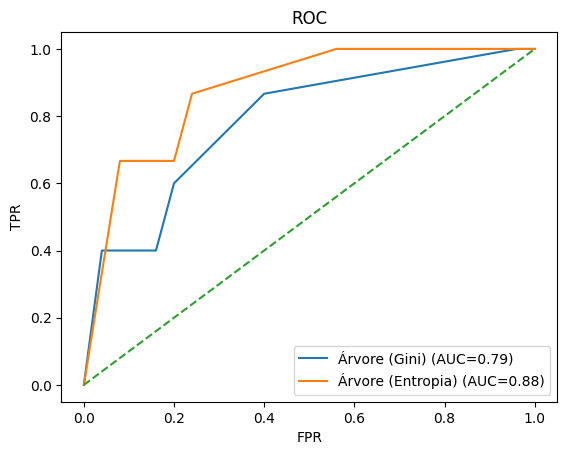

In [8]:
# Separa√ß√£o das features (vari√°veis independentes) e target (vari√°vel dependente)
# Remove a coluna 'selecionado' do DataFrame e armazena todas as outras colunas em X
X = df.drop(columns=['selecionado'])
# Armazena apenas a coluna 'selecionado' em y (nossa vari√°vel alvo)
y = df['selecionado']

# Defini√ß√£o das colunas categ√≥ricas e num√©ricas do dataset
# Lista das colunas que cont√™m dados categ√≥ricos
cat_cols = ['ingles','formacao']
# Lista das colunas num√©ricas (todas as colunas que n√£o est√£o em cat_cols)
num_cols = [c for c in X.columns if c not in cat_cols]

# Cria√ß√£o do preprocessador para transformar dados categ√≥ricos
# ColumnTransformer √© usado para aplicar diferentes transforma√ß√µes em diferentes colunas
pre = ColumnTransformer([
    # OneHotEncoder para transformar vari√°veis categ√≥ricas em formato num√©rico
    # handle_unknown='ignore' permite lidar com categorias n√£o vistas no treino
    # sparse_output=False retorna uma matriz densa ao inv√©s de esparsa
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')  # 'passthrough' mant√©m as colunas num√©ricas inalteradas

# Cria√ß√£o de dois modelos de √°rvore de decis√£o com diferentes crit√©rios de divis√£o
# Pipeline combina preprocessamento e modelo em uma √∫nica unidade
tree_gini = Pipeline([
    ('pre', pre),  # Primeiro aplica o preprocessamento definido acima
    # √Årvore de decis√£o usando √≠ndice Gini como crit√©rio de divis√£o
    ('clf', DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42))
])
tree_ent = Pipeline([
    ('pre', pre),  # Mesmo preprocessamento
    # √Årvore de decis√£o usando entropia como crit√©rio de divis√£o
    ('clf', DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42))
])

# Divis√£o dos dados em conjuntos de treino e teste
# test_size=0.25 significa que 25% dos dados ser√£o usados para teste
# random_state=42 garante reprodutibilidade
# stratify=y mant√©m a propor√ß√£o das classes no conjunto de treino e teste
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Treinamento dos modelos com os dados de treino
tree_gini.fit(X_tr, y_tr)  # Treina o modelo usando crit√©rio Gini
tree_ent.fit(X_tr, y_tr)   # Treina o modelo usando crit√©rio Entropia

# Fun√ß√£o para avaliar o desempenho dos modelos
def eval_model(name, pipe):
    # Faz previs√µes no conjunto de teste
    y_pred = pipe.predict(X_te)  # Previs√µes das classes
    y_proba = pipe.predict_proba(X_te)[:,1]  # Probabilidades das previs√µes (classe positiva)
    
    # Calcula diferentes m√©tricas de avalia√ß√£o
    acc = accuracy_score(y_te, y_pred)      # Acur√°cia: propor√ß√£o de previs√µes corretas
    prec = precision_score(y_te, y_pred)    # Precis√£o: propor√ß√£o de verdadeiros positivos
    rec = recall_score(y_te, y_pred)        # Recall: taxa de detec√ß√£o de positivos
    f1 = f1_score(y_te, y_pred)            # F1-Score: m√©dia harm√¥nica entre precis√£o e recall
    
    # Calcula pontos para a curva ROC
    fpr, tpr, _ = roc_curve(y_te, y_proba)  # False Positive Rate e True Positive Rate
    roc_auc = auc(fpr, tpr)                 # √Årea sob a curva ROC
    
    # Imprime as m√©tricas de avalia√ß√£o
    print(f"\n{name}")
    print(f"Acc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | F1={f1:.3f} | ROC-AUC={roc_auc:.3f}")
    
    # Calcula e imprime a matriz de confus√£o
    cm = confusion_matrix(y_te, y_pred)
    print("Matriz de confus√£o:\n", cm)
    
    # Plota a curva ROC para o modelo atual
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
    return fpr, tpr, roc_auc

# Cria√ß√£o do gr√°fico para as curvas ROC
plt.figure()  # Cria uma nova figura
# Avalia e plota resultados para ambos os modelos
eval_model("√Årvore (Gini)", tree_gini)
eval_model("√Årvore (Entropia)", tree_ent)
# Adiciona a linha de refer√™ncia (random classifier)
plt.plot([0,1],[0,1],'--')
# Configura r√≥tulos e t√≠tulo do gr√°fico
plt.xlabel("FPR")  # False Positive Rate no eixo X
plt.ylabel("TPR")  # True Positive Rate no eixo Y
plt.title("ROC")   # T√≠tulo do gr√°fico
plt.legend()       # Adiciona legenda
plt.show()         # Exibe o gr√°fico


## 4. Visualizar a √°rvore treinada

Para visualiza√ß√£o simples, extra√≠mos a √°rvore do pipeline e usamos `plot_tree`.
As **cores** indicam classes, e cada n√≥ mostra a **impureza (gini)**, **amostras** e a **distribui√ß√£o**.


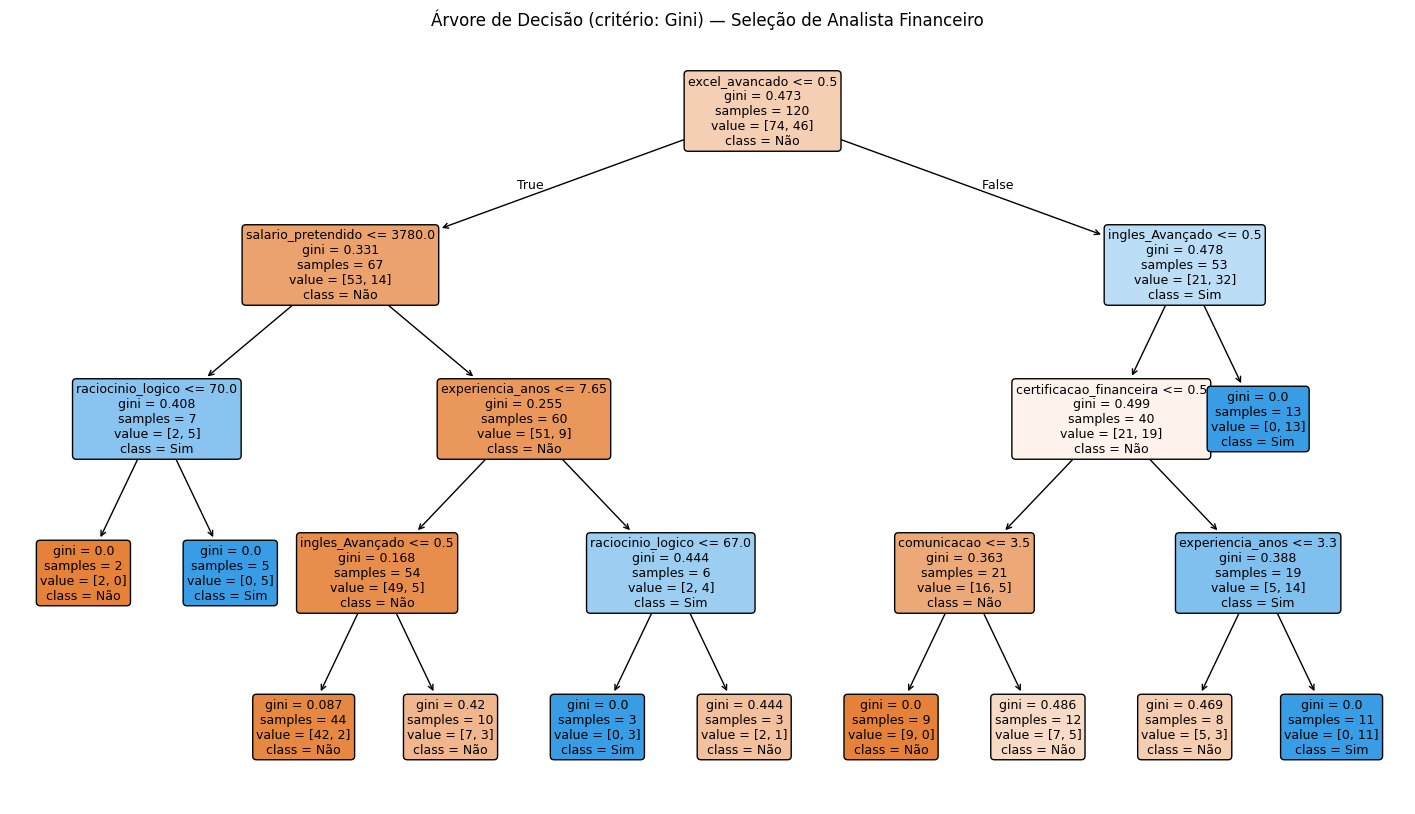

In [9]:

# Extra: visualizar a √°rvore do modelo Gini
# Cria uma figura grande para visualizar bem a √°rvore
plt.figure(figsize=(18,10))
# Para plot_tree, precisamos das features ap√≥s o OneHotEncoder:
Nomes_Features = tree_gini.named_steps['pre'].named_transformers_['onehot'] # extrai o OneHotEncoder do pipeline 
oh_features = list(Nomes_Features.get_feature_names_out(['ingles','formacao'])) # nomes das features ap√≥s OneHotEncoding
all_features = oh_features + [c for c in X.columns if c not in ['ingles','formacao']] # todas as features finais

clf = tree_gini.named_steps['clf']

plot_tree(clf, feature_names=all_features, class_names=['N√£o','Sim'], filled=True, rounded=True, fontsize=9)
plt.title("√Årvore de Decis√£o (crit√©rio: Gini) ‚Äî Sele√ß√£o de Analista Financeiro")
plt.show()


[0 1]


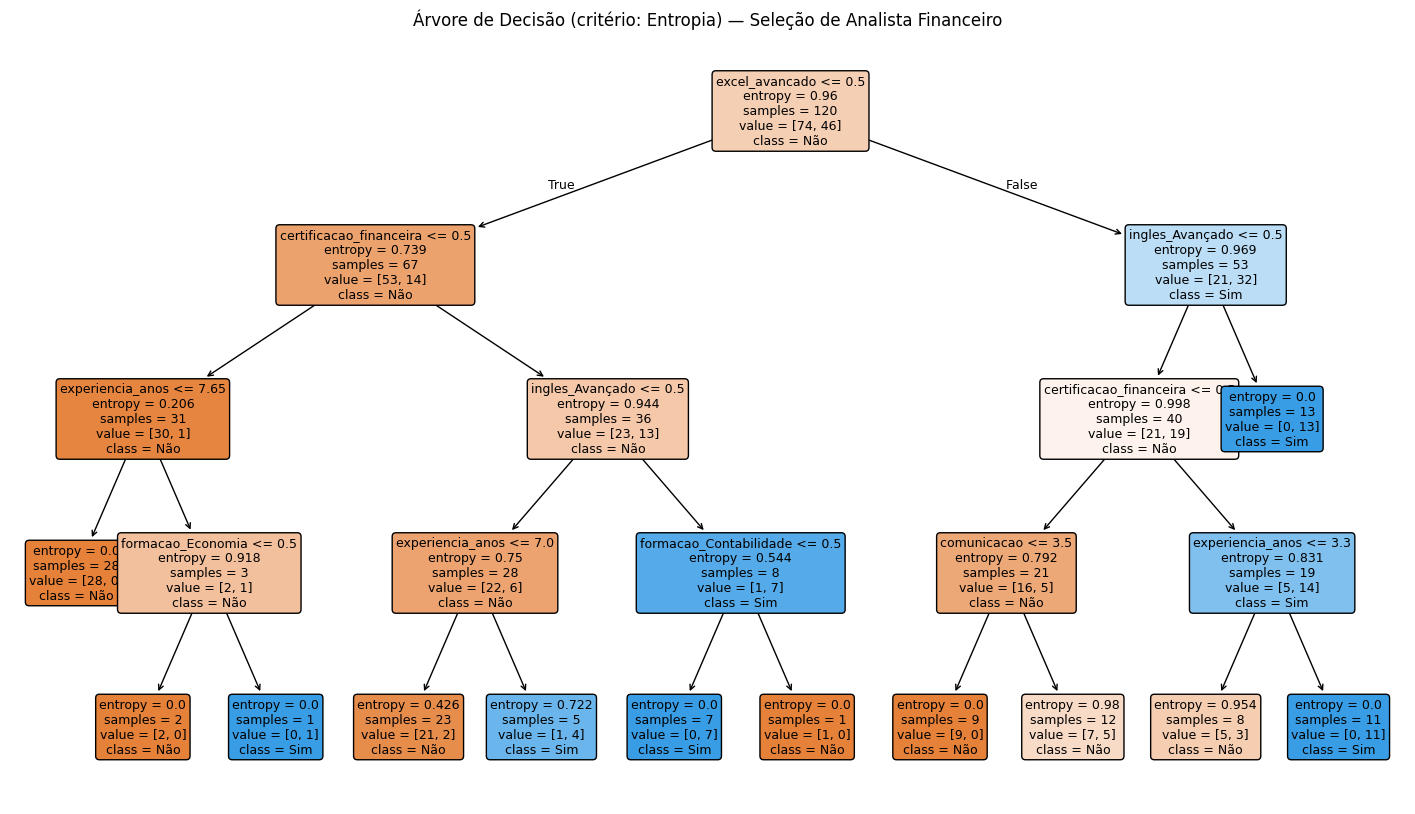

In [10]:
# Extrai o classificador (√°rvore de decis√£o) do pipeline
# named_steps['clf'] acessa o componente 'clf' do pipeline
clf = tree_ent.named_steps['clf'] # extrai o classificador do pipeline

# Cria uma figura grande para visualizar bem a √°rvore
plt.figure(figsize=(18,10))

# Plota a √°rvore de decis√£o com v√°rias configura√ß√µes visuais
# feature_names: nomes das caracter√≠sticas para mostrar nas decis√µes
# class_names: nomes das classes para mostrar nas folhas
# filled=True: preenche os n√≥s com cores baseadas na classe majorit√°ria
# rounded=True: usa cantos arredondados nos n√≥s
# fontsize=9: define o tamanho da fonte para legibilidade
plot_tree(clf, feature_names=all_features, class_names=['N√£o','Sim'], 
          filled=True, rounded=True, fontsize=9)
print(clf.classes_)
# Adiciona um t√≠tulo explicativo ao gr√°fico
plt.title("√Årvore de Decis√£o (crit√©rio: Entropia) ‚Äî Sele√ß√£o de Analista Financeiro")

# Exibe o gr√°fico
plt.show()


## 5. Import√¢ncia das vari√°veis

A import√¢ncia mede a **redu√ß√£o m√©dia de impureza** (MDI) causada por cada feature ao longo da √°rvore.


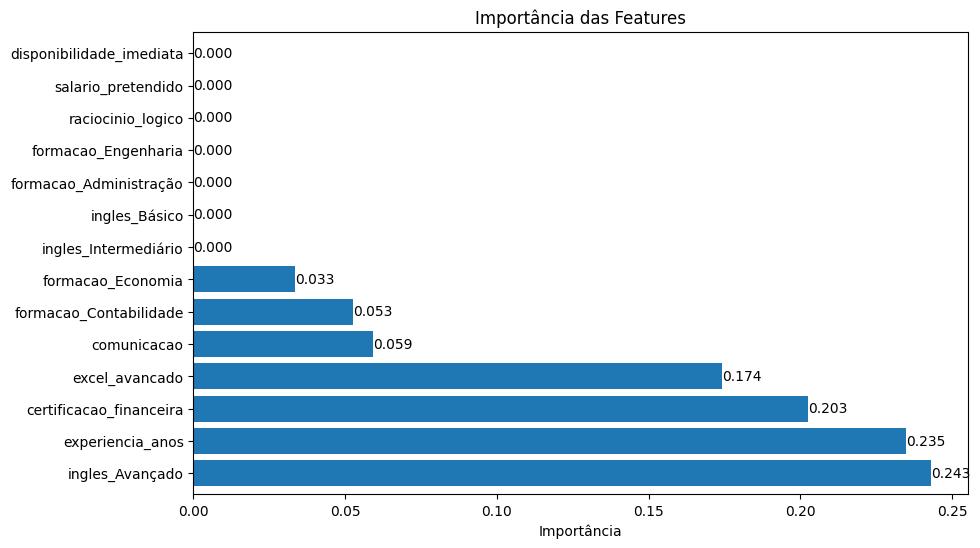

In [11]:
# Obt√©m as import√¢ncias das caracter√≠sticas do modelo
# feature_importances_ √© um atributo que indica quanto cada feature contribui para as decis√µes
importances = pd.Series(clf.feature_importances_, index=all_features)

# Ordena as import√¢ncias em ordem decrescente
importances = importances.sort_values(ascending=False)

# Cria um gr√°fico de barras horizontais para visualizar as import√¢ncias
plt.figure(figsize=(10,6))
# barh cria barras horizontais
# width=0.8 controla a largura das barras
importances.plot(kind='barh', width=0.8)

# Personaliza o gr√°fico
plt.title("Import√¢ncia das Features")  # Adiciona t√≠tulo
plt.xlabel("Import√¢ncia")              # R√≥tulo do eixo x

# Exibe os valores num√©ricos ao lado das barras
for i, v in enumerate(importances):
    # Adiciona texto com o valor formatado com 3 casas decimais
    plt.text(v, i, f'{v:.3f}', va='center')

## üå≥ Como ler a √Årvore de Decis√£o

Cada **caixinha** da √°rvore mostra um grupo de dados e as regras que o modelo aprendeu para separar as classes (por exemplo: **Selecionado** ou **N√£o selecionado**).

---

### üß© Exemplo de n√≥

```
excel_avancado <= 0.5
entropy = 0.96
samples = 120
value = [74, 46]
class = N√£o
```

---

### üß† O que significa cada linha

| Linha | Significado |
|-------|--------------|
| **excel_avancado <= 0.5** | Regra usada para dividir os dados (quem tem ou n√£o Excel avan√ßado). |
| **entropy = 0.96** | Mede o quanto o grupo est√° misturado (0 = puro, 1 = muito misturado). |
| **samples = 120** | Quantas pessoas chegaram at√© esse ponto da √°rvore. |
| **value = [74, 46]** | Quantas s√£o da classe **N√£o** e quantas da classe **Sim**. |
| **class = N√£o** | A classe mais comum nesse grupo (o que o modelo prev√™). |

---

### üçÉ Folhas

As **folhas** s√£o os n√≥s finais ‚Äî onde o modelo **para de dividir** e **d√° uma resposta**.

Exemplo:
```
samples = 13
value = [0, 13]
class = Sim
```
‚û°Ô∏è Todos s√£o da classe **Sim**, ent√£o o modelo prev√™ **Sim** para quem cair aqui.

---

### ‚öôÔ∏è Em resumo

- **N√≥s internos:** fazem perguntas (divis√µes).  
- **Folhas:** mostram a decis√£o final.  
- **Menor entropia ou gini = grupo mais puro.**  
- **Classe = resposta que o modelo dar√°.**



## 6. Simular a triagem de novos candidatos

Monte um dicion√°rio com os dados do candidato e verifique a previs√£o.


In [12]:
# ---------- 1) Candidato de teste ----------
candidate_full = {
    "experiencia_anos": 4,
    "certificacao_financeira": 1,
    "ingles": "Intermedi√°rio",
    "excel_avancado": 0,
    "formacao": "Contabilidade",
    "raciocinio_logico": 8.0,
    "salario_pretendido": 4500.0,
    "comunicacao": 7.5,
    "disponibilidade_imediata": 0
}

novo_candidato = pd.DataFrame([candidate_full])

print("=== Perfil do Candidato ===")
display(novo_candidato)

# ---------- 2) Predi√ß√£o para o candidato ----------
prob = tree_ent.predict_proba(novo_candidato)[0, 1]
pred = tree_ent.predict(novo_candidato)[0]
print(f"Probabilidade de ser selecionado Entropy: {prob:.2%}")
print("Predi√ß√£o final:", "Selecionado" if pred==1 else "N√£o Selecionado")

prob = tree_gini.predict_proba(novo_candidato)[0, 1]
pred = tree_gini.predict(novo_candidato)[0]
print(f"Probabilidade de ser selecionado GINI: {prob:.2%}")
print("Predi√ß√£o final:", "Selecionado" if pred==1 else "N√£o Selecionado")

=== Perfil do Candidato ===


experiencia_anos  certificacao_financeira         ingles  excel_avancado  \
0                 4                        1  Intermedi√°rio               0   

        formacao  raciocinio_logico  salario_pretendido  comunicacao  \
0  Contabilidade                8.0              4500.0          7.5   

   disponibilidade_imediata  
0                         0

Probabilidade de ser selecionado Entropy: 8.70%
Predi√ß√£o final: N√£o Selecionado
Probabilidade de ser selecionado GINI: 4.55%
Predi√ß√£o final: N√£o Selecionado
